In [1]:
import datasets

dataset_wmt19 = datasets.load_dataset("wmt19", 'ru-en')
dataset_open_subtitles = datasets.load_dataset("open_subtitles", lang1="en", lang2="ru")


print("Size of WMT19 dataset: ", len(dataset_wmt19['train']))
print("Size of Open Subtitles dataset: ", len(dataset_open_subtitles['train']))

/Users/sergejsorin/study/hse_4_year_2024-2025/ds/project/.env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Size of WMT19 dataset:  37492126
Size of Open Subtitles dataset:  25910105


In [2]:
dataset_open_subtitles['train'][0]

{'id': '0',
 'meta': {'year': 0,
  'imdbId': 1730059,
  'subtitleId': {'en': 5554838, 'ru': 4603300},
  'sentenceIds': {'en': [1], 'ru': [2]}},
 'translation': {'en': 'Kids can get pretty much anything they want in the yard, as long as they can afford it.',
  'ru': 'Дети могут достать во дворе почти всё что угодно до тех пор, пока могут себе это позволить.'}}

# Подбор датасета и токенайзера

Так как мы хотим построить маленькую, но эффективную модель, нам нужно определить размер контекстного окна трансформера и токенайзер, который будет использоваться.

Чем лучше токенайзер - тем лучше он сжимает входные данные в токены, но с другой стороны - тем больше разрастается матрица входных и выходных эмбедингов (матрица размера (размер словаря) * (размерность эмбедингов в модели)).

Поэтому мы возьмем несколько датасетов ("open_subtitles", lang1="en", lang2="ru") и ("wmt19", 'ru-en'), и на каждом посчитаем среднее количество токенов в фразе, и какой процент из них влезет в 64 токена. Так как вычислительные затраты растут линейно от размера датасета, будем так же примерно вычислять "сложность" датасета как (средний размер данных в токенах) * (размер датасета)



In [12]:
from transformers import AutoTokenizer
tokenizers_names = [
    "Helsinki-NLP/opus-mt-en-ru",
    "facebook/mbart-large-50",
    # "google/mt5-base",
    # "facebook/wmt19-ru-en",
    # "t5-base",
    "xlm-roberta-base",
    "cointegrated/LaBSE-en-ru"
]

tokenizers = []
for name in tokenizers_names:
    tokenizer = AutoTokenizer.from_pretrained(name)
    tokenizers.append({"name": name, "tokenizer": tokenizer})
    

In [13]:
import pandas as pd
pd.options.display.float_format = '{:,.0f}'.format
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import numpy as np

def analyze_dataset(dataset_name, tokenizers, sample_size=10000):
    if dataset_name == "open_subtitles":
        dataset = datasets.load_dataset("open_subtitles", lang1="en", lang2="ru")
        src_lang, tgt_lang = 'en', 'ru'
    elif dataset_name == "wmt19":
        dataset = datasets.load_dataset("wmt19", 'ru-en')
        src_lang, tgt_lang = 'en', 'ru'
    
    results = []
    
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    axes = axes.ravel()
    
    for idx, tok_dict in enumerate(tokenizers):
        name = tok_dict["name"]
        tokenizer = tok_dict["tokenizer"]
        
        src_lengths = []
        tgt_lengths = []
        
        for i in tqdm(range(sample_size), desc=name):
            sample = dataset['train'][i]
            if dataset_name == "open_subtitles":
                src_text = sample['translation'][src_lang]
                tgt_text = sample['translation'][tgt_lang]
            else:
                src_text = sample['translation'][src_lang]
                tgt_text = sample['translation'][tgt_lang]
            
            src_lengths.append(len(tokenizer.encode(src_text)))
            tgt_lengths.append(len(tokenizer.encode(tgt_text)))
            
        src_lengths = np.array(src_lengths)
        tgt_lengths = np.array(tgt_lengths)
        
        # Plot
        ax = axes[idx]
        ax.hist(src_lengths, bins=50, alpha=0.5, label=f'{src_lang} (fit: {(src_lengths <= 128).mean() * 100:.1f}%)')
        ax.hist(tgt_lengths, bins=50, alpha=0.5, label=f'{tgt_lang} (fit: {(tgt_lengths <= 128).mean() * 100:.1f}%)')
        ax.axvline(x=128, color='r', linestyle='--')
        ax.set_title(f'{name}\nVocab: {len(tokenizer.get_vocab()):,}')
        ax.legend()
        
        # Collect stats
        results.append({
            'tokenizer': name,
            'vocab_size': len(tokenizer.get_vocab()),
            f'{src_lang}_mean_length': src_lengths.mean(),
            f'{tgt_lang}_mean_length': tgt_lengths.mean(),
            f'{src_lang}_median_length': np.median(src_lengths),
            f'{tgt_lang}_median_length': np.median(tgt_lengths),
            f'{src_lang}_fit_128': (src_lengths <= 128).mean() * 100,
            f'{tgt_lang}_fit_128': (tgt_lengths <= 128).mean() * 100,
            'complexity_score': len(tokenizer.get_vocab()) * (src_lengths.mean() + tgt_lengths.mean()) / 2
        })
    
    plt.tight_layout()
    return pd.DataFrame(results).sort_values('complexity_score')


cointegrated/LaBSE-en-ru: 100%|██████████| 10000/10000 [00:01<00:00, 8073.68it/s]


,tokenizer,vocab_size,en_mean_length,ru_mean_length,en_median_length,ru_median_length,en_fit_128,ru_fit_128,complexity_score
3,cointegrated/LaBSE-en-ru,55083,12,10,10,8,100,100,"624,561"
0,Helsinki-NLP/opus-mt-en-ru,62518,12,29,9,23,100,99,"1,279,900"
2,xlm-roberta-base,250002,13,10,10,9,100,100,"2,867,885"
1,facebook/mbart-large-50,250054,13,10,10,9,100,100,"2,868,482"


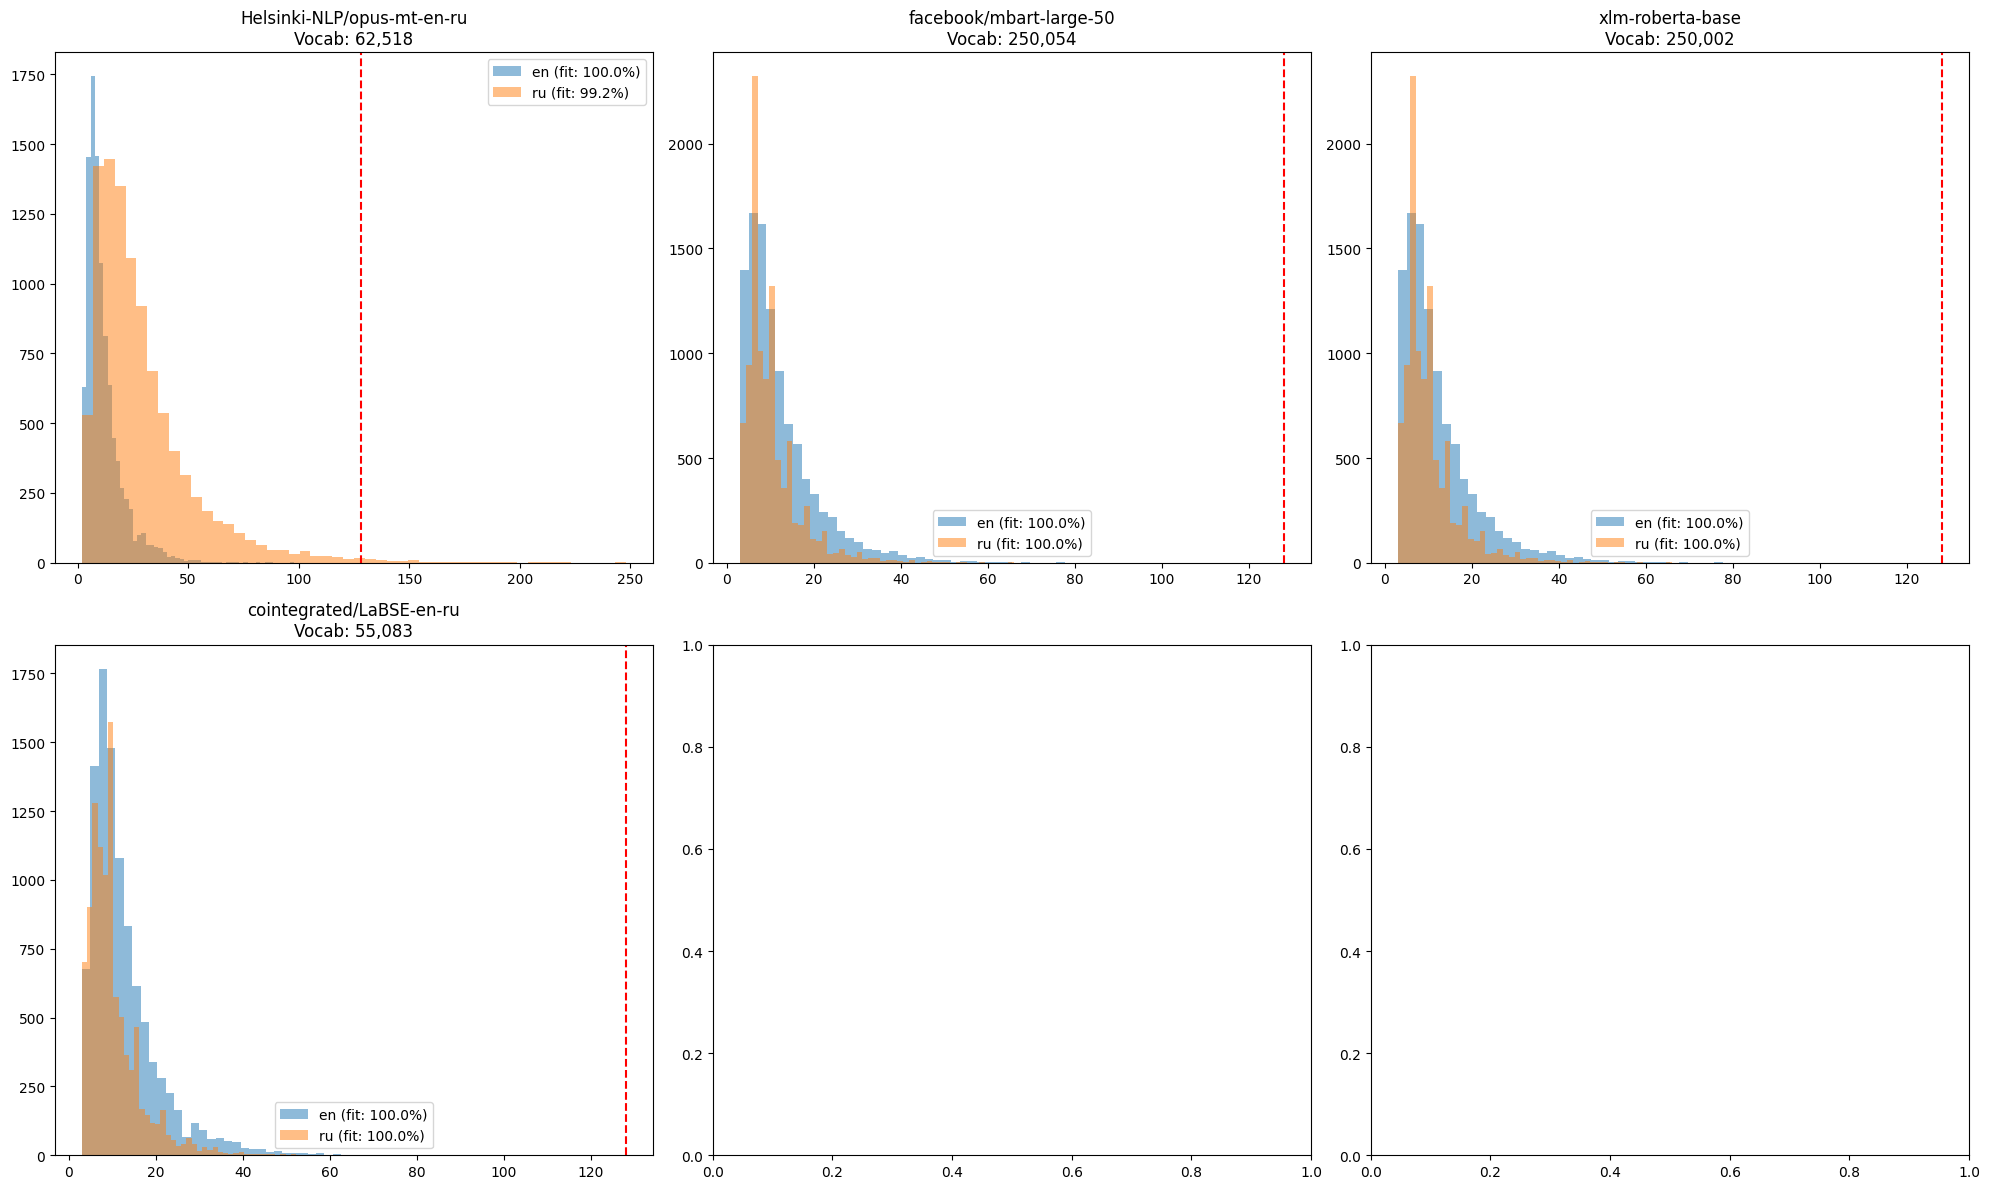

In [14]:
df_subtitles = analyze_dataset("open_subtitles", tokenizers)
display(df_subtitles)
df_subtitles.to_csv("open_subtitles_tokenizers.csv", index=False)

cointegrated/LaBSE-en-ru: 100%|██████████| 10000/10000 [00:01<00:00, 8558.49it/s]


,tokenizer,vocab_size,en_mean_length,ru_mean_length,en_median_length,ru_median_length,en_fit_128,ru_fit_128,complexity_score
3,cointegrated/LaBSE-en-ru,55083,16,17,8,8,100,100,"901,056"
0,Helsinki-NLP/opus-mt-en-ru,62518,16,47,8,10,100,88,"1,988,679"
2,xlm-roberta-base,250002,17,18,9,9,100,100,"4,368,947"
1,facebook/mbart-large-50,250054,17,18,9,9,100,100,"4,369,856"


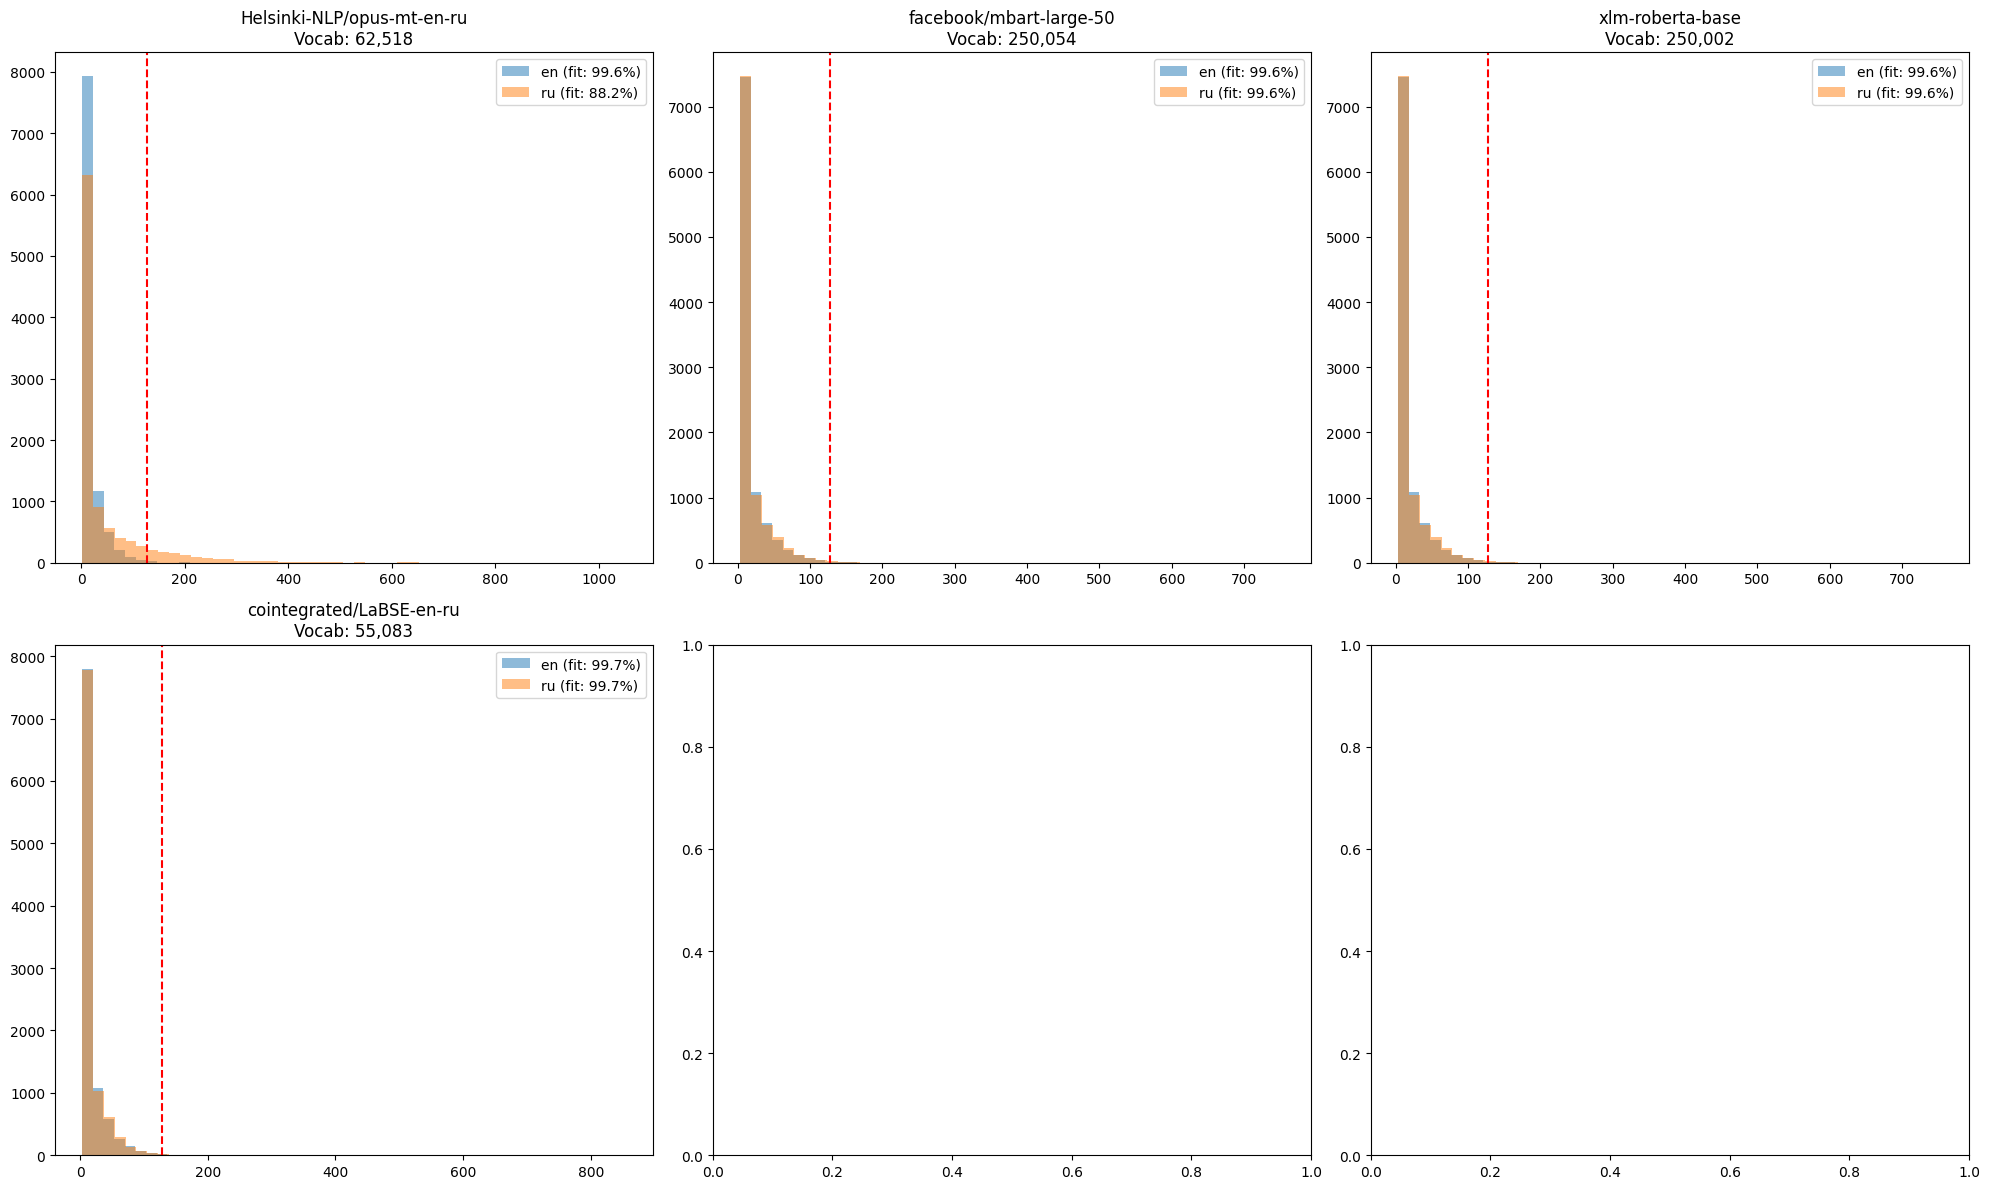

In [15]:
df_wmt = analyze_dataset("wmt19", tokenizers)
display(df_wmt)
df_wmt.to_csv("wmt19_tokenizers.csv", index=False)

Вывод

Используем `facebook/wmt19-ru-en`	, так как он самый эффективный, и хорошо обрабатывает все датасеты

In [16]:
import random

def show_samples(dataset_name, n=10):
    if dataset_name == "open_subtitles":
        ds = datasets.load_dataset("open_subtitles", lang1="en", lang2="ru")['train']
    else:
        ds = datasets.load_dataset("wmt19", 'ru-en')['train']
    
    indices = random.sample(range(len(ds)), n)
    samples = []
    
    for idx in indices:
        sample = ds[idx]
        if dataset_name == "open_subtitles":
            samples.append({
                'en': sample['translation']['en'],
                'ru': sample['translation']['ru']
            })
        else:
            samples.append({
                'en': sample['translation']['en'],
                'ru': sample['translation']['ru']
            })
    
    df = pd.DataFrame(samples)
    print(f"\n{dataset_name} samples:")
    return df

print("OpenSubtitles:")
display(show_samples("open_subtitles"))

print("\nWMT19:")
display(show_samples("wmt19"))

OpenSubtitles:

open_subtitles samples:


,en,ru
0,"What, like he tripped over his own shovel?","Что, он споткнулся о собственную лопату?"
1,I've promised him my right eye.,Я обещал ему свой правый глаз.
2,What if you couldn't fix Conor?,А что если ты не сможешь исправить Конора?
3,What?,Что?
4,Wh... one... damn it.,Что? Один... Черт побери!
5,"Avoid street lights, and there'll be no shadow!","Избегайте уличных фонарей, вот и тени не будет!"
6,You're waking him up.,Ты его разбудишь.
7,One of the original betas.,Одна из первых бета-версий.
8,"- Now, now, now.","- Нет, нет, нет."
9,"Oh, I am putting the kettle on.",Я же поставила чайник.



WMT19:

wmt19 samples:


,en,ru
0,79. The employment situation in Guaremala is r...,79. В Гватемале положение в области труда хара...
1,Women were most strongly represented in qualif...,В программах повышения квалификации число женщ...
2,“Welcoming the report of the Secretary-General...,приветствуя доклад Генерального секретаря от 1...
3,:: The knowledge society is highly dynamic.,":: Общество, основанное на знаниях, является в..."
4,"Halkidiki, Greece",Греция
5,22630,22630
6,The development of future large water-supply s...,При создании будущих крупных систем водоснабже...
7,The Administrative Committee was informed by t...,24. Административный комитет был проинформиров...
8,"Today, one question seems very topical: have o...",Сегодня остается один весьма важный вопрос: ст...
9,In working to close gaps in the prevention con...,"Чтобы решить проблемы в области профилактики, ..."


Выберем датасет open_subtitles, так как он интереснее, и лучше показывает базовый перевод (без сложных терминов, в которых модели нужно будет научиться разбираться)